In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, f1_score

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
review=pd.read_excel(r"C:\Users\Vijay Rathod\Downloads\hotel_reviews.xlsx",sheet_name='hotel_reviews')
review

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


# Information about dataset

In [3]:
review.shape

(20491, 2)

In [4]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
review[review.duplicated()]  ### To see the Duplicate Reviews

,Review,Rating


In [6]:
review.isnull().sum()

Review    0
Rating    0
dtype: int64

In [7]:
review["Rating"].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

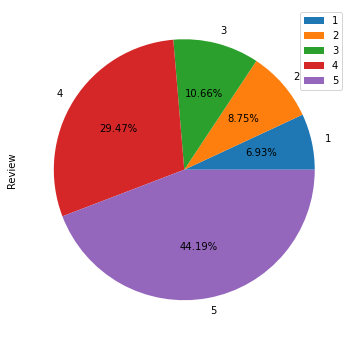

In [8]:
review.groupby("Rating").count().plot.pie(y="Review",autopct="%.2f%%",figsize=(6,6)); #rating in form of pie chart

In [9]:
review['Rating_sentiment'] = None
for index, rows in review.iterrows():
    if(rows['Rating'] >= 1 and rows['Rating'] < 3):
        review.at[index, 'Rating_sentiment'] = 'Negitive'
    elif(rows['Rating'] == 3):
        review.at[index,'Rating_sentiment'] = 'Neutral'
    elif(rows['Rating'] > 3 and rows['Rating'] <= 5 ):
        review.at[index,'Rating_sentiment'] = 'Positive'
review.head()

,Review,Rating,Rating_sentiment
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negitive
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive


Text(0.5, 1.0, 'Frequency of Ratings')

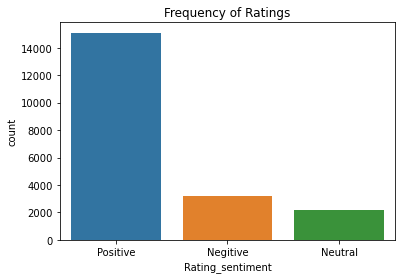

In [10]:
sns.countplot(x='Rating_sentiment',data=review ).set_title("Frequency of Ratings")

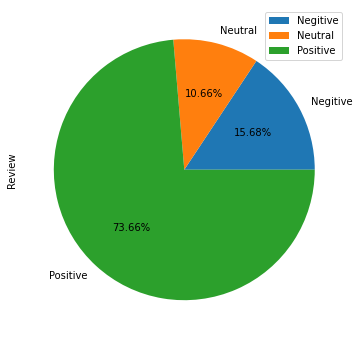

In [11]:
review.groupby("Rating_sentiment").count().plot.pie(y="Review",autopct="%.2f%%",figsize=(6,6));

In [12]:
review["Rating_sentiment"].value_counts()

Positive    15093
Negitive     3214
Neutral      2184
Name: Rating_sentiment, dtype: int64

# TEXT PRE-PROCESSING

Exploratory Data Analusis (EDA)

Expanding Contractions


In [13]:
import contractions
review['no_contract'] = review['Review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
review['no_contract']

0        [nice, hotel, expensive, parking, got, good, d...
1        [ok, nothing, special, charge, diamond, member...
2        [nice, rooms, not, 4*, experience, hotel, mona...
3        [unique,, great, stay,, wonderful, time, hotel...
4        [great, stay, great, stay,, went, seahawk, gam...
                               ...                        
20486    [best, kept, secret, 3rd, time, staying, charm...
20487    [great, location, price, view, hotel, great, q...
20488    [ok, just, looks, nice, modern, outside,, desk...
20489    [hotel, theft, ruined, vacation, hotel, opened...
20490    [people, talking,, ca, n't, believe, excellent...
Name: no_contract, Length: 20491, dtype: object

In [14]:
review['content_str'] = [' '.join(map(str, l)) for l in review['no_contract']]
review['content_str']

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice rooms not 4* experience hotel monaco seat...
3        unique, great stay, wonderful time hotel monac...
4        great stay great stay, went seahawk game aweso...
                               ...                        
20486    best kept secret 3rd time staying charm, not 5...
20487    great location price view hotel great quick pl...
20488    ok just looks nice modern outside, desk staff ...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking, ca n't believe excellent ratin...
Name: content_str, Length: 20491, dtype: object

# Removing Punctuations

In [15]:
review['no_punc'] = review['content_str'].str.replace('[^\w\s]','')
review

,Review,Rating,Rating_sentiment,no_contract,content_str,no_punc
0,nice hotel expensive parking got good deal sta...,4,Positive,"[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,Negitive,"[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral,"[nice, rooms, not, 4*, experience, hotel, mona...",nice rooms not 4* experience hotel monaco seat...,nice rooms not 4 experience hotel monaco seatt...
3,"unique, great stay, wonderful time hotel monac...",5,Positive,"[unique,, great, stay,, wonderful, time, hotel...","unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,Positive,"[great, stay, great, stay,, went, seahawk, gam...","great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...
...,...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,Positive,"[best, kept, secret, 3rd, time, staying, charm...","best kept secret 3rd time staying charm, not 5...",best kept secret 3rd time staying charm not 5s...
20487,great location price view hotel great quick pl...,4,Positive,"[great, location, price, view, hotel, great, q...",great location price view hotel great quick pl...,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ...",2,Negitive,"[ok, just, looks, nice, modern, outside,, desk...","ok just looks nice modern outside, desk staff ...",ok just looks nice modern outside desk staff n...
20489,hotel theft ruined vacation hotel opened sept ...,1,Negitive,"[hotel, theft, ruined, vacation, hotel, opened...",hotel theft ruined vacation hotel opened sept ...,hotel theft ruined vacation hotel opened sept ...


# Tokenization

In [16]:
from nltk.tokenize import word_tokenize
review['tokenized'] = review['no_punc'].apply(word_tokenize)
review.iloc[:,2:]

,Rating_sentiment,no_contract,content_str,no_punc,tokenized
0,Positive,"[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d..."
1,Negitive,"[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member..."
2,Neutral,"[nice, rooms, not, 4*, experience, hotel, mona...",nice rooms not 4* experience hotel monaco seat...,nice rooms not 4 experience hotel monaco seatt...,"[nice, rooms, not, 4, experience, hotel, monac..."
3,Positive,"[unique,, great, stay,, wonderful, time, hotel...","unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ..."
4,Positive,"[great, stay, great, stay,, went, seahawk, gam...","great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game..."
...,...,...,...,...,...
20486,Positive,"[best, kept, secret, 3rd, time, staying, charm...","best kept secret 3rd time staying charm, not 5...",best kept secret 3rd time staying charm not 5s...,"[best, kept, secret, 3rd, time, staying, charm..."
20487,Positive,"[great, location, price, view, hotel, great, q...",great location price view hotel great quick pl...,great location price view hotel great quick pl...,"[great, location, price, view, hotel, great, q..."
20488,Negitive,"[ok, just, looks, nice, modern, outside,, desk...","ok just looks nice modern outside, desk staff ...",ok just looks nice modern outside desk staff n...,"[ok, just, looks, nice, modern, outside, desk,..."
20489,Negitive,"[hotel, theft, ruined, vacation, hotel, opened...",hotel theft ruined vacation hotel opened sept ...,hotel theft ruined vacation hotel opened sept ...,"[hotel, theft, ruined, vacation, hotel, opened..."


# Normalize the data

In [17]:
review['lower'] = review['tokenized'].apply(lambda x: [word.lower() for word in x])
review.iloc[:,4:]

,content_str,no_punc,tokenized,lower
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member..."
2,nice rooms not 4* experience hotel monaco seat...,nice rooms not 4 experience hotel monaco seatt...,"[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, not, 4, experience, hotel, monac..."
3,"unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game..."
...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",best kept secret 3rd time staying charm not 5s...,"[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, 3rd, time, staying, charm..."
20487,great location price view hotel great quick pl...,great location price view hotel great quick pl...,"[great, location, price, view, hotel, great, q...","[great, location, price, view, hotel, great, q..."
20488,"ok just looks nice modern outside, desk staff ...",ok just looks nice modern outside desk staff n...,"[ok, just, looks, nice, modern, outside, desk,...","[ok, just, looks, nice, modern, outside, desk,..."
20489,hotel theft ruined vacation hotel opened sept ...,hotel theft ruined vacation hotel opened sept ...,"[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruined, vacation, hotel, opened..."


# Removing Stopwords

In [18]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
review['no_stopword'] = review['lower'].apply(lambda x: [word for word in x if word not in stop_words])
review.iloc[:,4:]

,content_str,no_punc,tokenized,lower,no_stopword
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member..."
2,nice rooms not 4* experience hotel monaco seat...,nice rooms not 4 experience hotel monaco seatt...,"[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, 4, experience, hotel, monaco, se..."
3,"unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game..."
...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",best kept secret 3rd time staying charm not 5s...,"[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, 3rd, time, staying, charm..."
20487,great location price view hotel great quick pl...,great location price view hotel great quick pl...,"[great, location, price, view, hotel, great, q...","[great, location, price, view, hotel, great, q...","[great, location, price, view, hotel, great, q..."
20488,"ok just looks nice modern outside, desk staff ...",ok just looks nice modern outside desk staff n...,"[ok, just, looks, nice, modern, outside, desk,...","[ok, just, looks, nice, modern, outside, desk,...","[ok, looks, nice, modern, outside, desk, staff..."
20489,hotel theft ruined vacation hotel opened sept ...,hotel theft ruined vacation hotel opened sept ...,"[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruined, vacation, hotel, opened..."


# Number of words

In [19]:
#Number of Words in single review
review['no_word'] = review['no_stopword'].apply(lambda x: len(str(x).split(" ")))
review.iloc[:,6:]

,tokenized,lower,no_stopword,no_word
0,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...",81
1,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...",237
2,"[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, 4, experience, hotel, monaco, se...",211
3,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...",86
4,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...",180
...,...,...,...,...
20486,"[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, 3rd, time, staying, charm...",107
20487,"[great, location, price, view, hotel, great, q...","[great, location, price, view, hotel, great, q...","[great, location, price, view, hotel, great, q...",39
20488,"[ok, just, looks, nice, modern, outside, desk,...","[ok, just, looks, nice, modern, outside, desk,...","[ok, looks, nice, modern, outside, desk, staff...",61
20489,"[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruined, vacation, hotel, opened...",753


# Number of Characters

In [20]:
#Number of characters in single review 
review['char_count'] = review['no_punc'].str.len() 
review.iloc[:,6:]


,tokenized,lower,no_stopword,no_word,char_count
0,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...",81,579
1,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...",237,1661
2,"[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, 4, experience, hotel, monaco, se...",211,1393
3,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...",86,582
4,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...",180,1239
...,...,...,...,...,...
20486,"[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, 3rd, time, staying, charm...","[best, kept, secret, 3rd, time, staying, charm...",107,713
20487,"[great, location, price, view, hotel, great, q...","[great, location, price, view, hotel, great, q...","[great, location, price, view, hotel, great, q...",39,299
20488,"[ok, just, looks, nice, modern, outside, desk,...","[ok, just, looks, nice, modern, outside, desk,...","[ok, looks, nice, modern, outside, desk, staff...",61,431
20489,"[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruined, vacation, hotel, opened...","[hotel, theft, ruined, vacation, hotel, opened...",753,5461


# Stemming

In [21]:
review['stp_rem_str'] = [' '.join(map(str, l)) for l in review['no_stopword']]
from nltk.stem import PorterStemmer
st = PorterStemmer()
review['stemmi']=review['stp_rem_str'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
review.iloc[:,-1]

0        nice hotel expens park got good deal stay hote...
1        ok noth special charg diamond member hilton de...
2        nice room 4 experi hotel monaco seattl good ho...
3        uniqu great stay wonder time hotel monaco loca...
4        great stay great stay went seahawk game awesom...
                               ...                        
20486    best kept secret 3rd time stay charm 5star ca ...
20487    great locat price view hotel great quick place...
20488    ok look nice modern outsid desk staff nt parti...
20489    hotel theft ruin vacat hotel open sept 17 2007...
20490    peopl talk ca nt believ excel rate hotel nt ye...
Name: stemmi, Length: 20491, dtype: object

# Lemmatization

In [22]:
from textblob import Word
review['lemma'] = review['stp_rem_str'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
review.iloc[:,13]

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice room 4 experience hotel monaco seattle go...
3        unique great stay wonderful time hotel monaco ...
4        great stay great stay went seahawk game awesom...
                               ...                        
20486    best kept secret 3rd time staying charm 5star ...
20487    great location price view hotel great quick pl...
20488    ok look nice modern outside desk staff nt part...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking ca nt believe excellent rating ...
Name: lemma, Length: 20491, dtype: object

# Removing Numbers

In [23]:
import re
# Removing numbers form text
review['cleaned']=review['lemma'].apply(lambda x: re.sub('\w*\d\w*','', x))
review.iloc[:,-2:]

,lemma,cleaned
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice room 4 experience hotel monaco seattle go...,nice room experience hotel monaco seattle goo...
3,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...
...,...,...
20486,best kept secret 3rd time staying charm 5star ...,best kept secret time staying charm ca nt be...
20487,great location price view hotel great quick pl...,great location price view hotel great quick pl...
20488,ok look nice modern outside desk staff nt part...,ok look nice modern outside desk staff nt part...
20489,hotel theft ruined vacation hotel opened sept ...,hotel theft ruined vacation hotel opened sept ...


# advance cleaning 

In [24]:
def cleantext(text):
    text = re.sub(r"â€™", "", text) # Remove Mentions
    text = re.sub(r"#", "", text) # Remove Hashtags Symbol
    text = re.sub(r"\w*\d\w*", "", text) # Remove numbers
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove The Hyper Link
    text = re.sub(r"______________", "", text) # Remove _____
    
    
    return text

In [25]:
review['cleaned'] = review['cleaned'].apply(cleantext)
review.head()

,Review,Rating,Rating_sentiment,no_contract,content_str,no_punc,tokenized,lower,no_stopword,no_word,char_count,stp_rem_str,stemmi,lemma,cleaned
0,nice hotel expensive parking got good deal sta...,4,Positive,"[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...",81,579,nice hotel expensive parking got good deal sta...,nice hotel expens park got good deal stay hote...,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,Negitive,"[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...",237,1661,ok nothing special charge diamond member hilto...,ok noth special charg diamond member hilton de...,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral,"[nice, rooms, not, 4*, experience, hotel, mona...",nice rooms not 4* experience hotel monaco seat...,nice rooms not 4 experience hotel monaco seatt...,"[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, 4, experience, hotel, monaco, se...",211,1393,nice rooms 4 experience hotel monaco seattle g...,nice room 4 experi hotel monaco seattl good ho...,nice room 4 experience hotel monaco seattle go...,nice room experience hotel monaco seattle goo...
3,"unique, great stay, wonderful time hotel monac...",5,Positive,"[unique,, great, stay,, wonderful, time, hotel...","unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...",86,582,unique great stay wonderful time hotel monaco ...,uniqu great stay wonder time hotel monaco loca...,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,Positive,"[great, stay, great, stay,, went, seahawk, gam...","great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...",180,1239,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...


In [26]:
review['cleaned']

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice room  experience hotel monaco seattle goo...
3        unique great stay wonderful time hotel monaco ...
4        great stay great stay went seahawk game awesom...
                               ...                        
20486    best kept secret  time staying charm  ca nt be...
20487    great location price view hotel great quick pl...
20488    ok look nice modern outside desk staff nt part...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking ca nt believe excellent rating ...
Name: cleaned, Length: 20491, dtype: object

# TFIDF - Term frequency inverse Document Frequency

In [27]:

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features= 10000, max_df = 0.5, smooth_idf=True) #keep top 1000 words
TFIDF= vectorizer.fit_transform(review["cleaned"])
names_features = vectorizer.get_feature_names()
dense= TFIDF.todense()
denselist =dense.tolist()
df = pd.DataFrame(denselist, columns = names_features)
df

,aa,aaa,aalders,ab,aback,abandoned,abc,ability,abit,able,...,zen,zero,zillion,zip,zocalo,zona,zone,zoo,zoologischer,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# N-gram

In [28]:
#Bi-gram
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

In [29]:
top2_words = get_top_n2_words(review["cleaned"], n=200) #top 200
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
top2_df

,Bi-gram,Freq
0,great location,2142
1,staff friendly,2089
2,ca nt,1809
3,room clean,1716
4,punta cana,1682
...,...,...
195,room quite,289
196,hotel really,289
197,staff member,288
198,highly recommended,286


[Text(0, 0, 'great location'),
 Text(1, 0, 'staff friendly'),
 Text(2, 0, 'ca nt'),
 Text(3, 0, 'room clean'),
 Text(4, 0, 'punta cana'),
 Text(5, 0, 'minute walk'),
 Text(6, 0, 'hotel great'),
 Text(7, 0, 'great hotel'),
 Text(8, 0, 'walking distance'),
 Text(9, 0, 'recommend hotel'),
 Text(10, 0, 'friendly helpful'),
 Text(11, 0, 'stayed hotel'),
 Text(12, 0, 'hotel room'),
 Text(13, 0, 'stayed night'),
 Text(14, 0, 'room service'),
 Text(15, 0, 'hotel staff'),
 Text(16, 0, 'hotel stayed'),
 Text(17, 0, 'stay hotel'),
 Text(18, 0, 'place stay'),
 Text(19, 0, 'room small')]

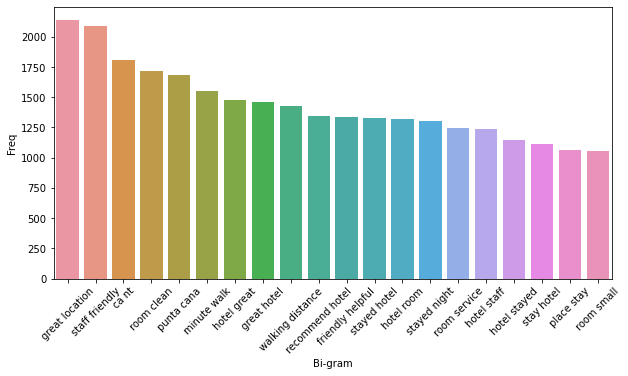

In [30]:
#Bi-gram plot
import matplotlib.pyplot as plt
import seaborn as sns
top20_bigram = top2_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sns.barplot(x=top20_bigram["Bi-gram"],y=top20_bigram["Freq"])
plot.set_xticklabels(rotation=45,labels = top20_bigram["Bi-gram"])

In [31]:
#tri-gram
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

In [32]:
top3_words = get_top_n3_words(review["cleaned"], n=200) #top 200
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["tri-gram", "Freq"]
top3_df

,tri-gram,Freq
0,staff friendly helpful,702
1,hotel great location,545
2,old san juan,354
3,highly recommend hotel,313
4,great place stay,273
...,...,...
195,air conditioning worked,46
196,hotel fantastic location,46
197,room clean bathroom,46
198,hotel great staff,46


# Visualizing positive and negative words using wordcloud

In [33]:
# Finding total words in Cleaned review
clean_review_words = " ".join(review['cleaned'])
clean_review_words = clean_review_words.split()
len(clean_review_words)# 1997097 words are present  


1997097

In [34]:
clean_review_words[0:10]

['nice',
 'hotel',
 'expensive',
 'parking',
 'got',
 'good',
 'deal',
 'stay',
 'hotel',
 'anniversary']

In [35]:
string_Total = " ".join(review["cleaned"])

In [36]:
from wordcloud import WordCloud
wordcloud_all = WordCloud(background_color='black', width=1800, height=1400, max_words=100).generate(string_Total)        

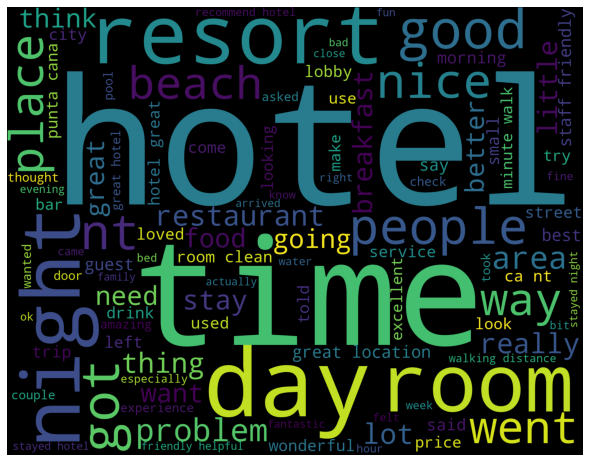

In [37]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_all) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show();

# Positive Word Cloud

In [38]:
# Using positive words 

with open("positive-words.txt",'r') as posi:
    posi_words = posi.read().split('\n')
posi_words = posi_words
posi_words[0:6]

['abundar', 'abunda', 'abundancia', 'abundante', 'accesible', 'aclamaciÃ³n']

In [39]:
text_pos = " ".join([w for w in clean_review_words if w in posi_words])
text_pos[0:25]

'ideal popular popular vic'

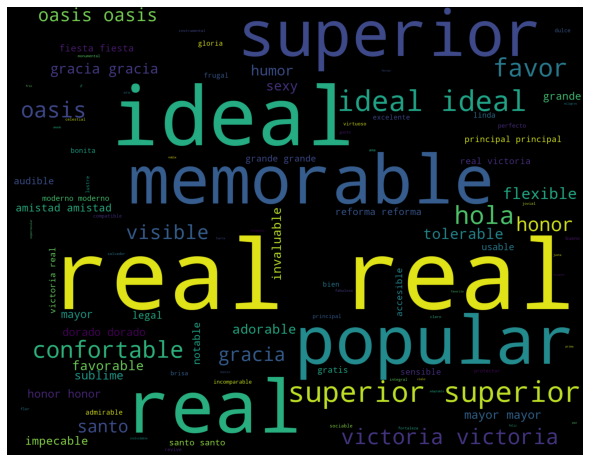

In [40]:
from wordcloud import WordCloud
wordcloud_pos = WordCloud(background_color='black', width=1800, height=1400, max_words=100).generate(text_pos)
                      
# plot the WordCloud image                        
plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show();

# Negative Word Cloud

In [41]:
# Using Negative words

with open ('negative-words.txt','r') as neg:
    negwords = neg.read().split("\n")
negwords = negwords[35:]
negwords[0:6]

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably']

In [42]:
text_neg = " ".join([w for w in clean_review_words if w in negwords])
text_neg[0:25]

'expensive disappointed no'

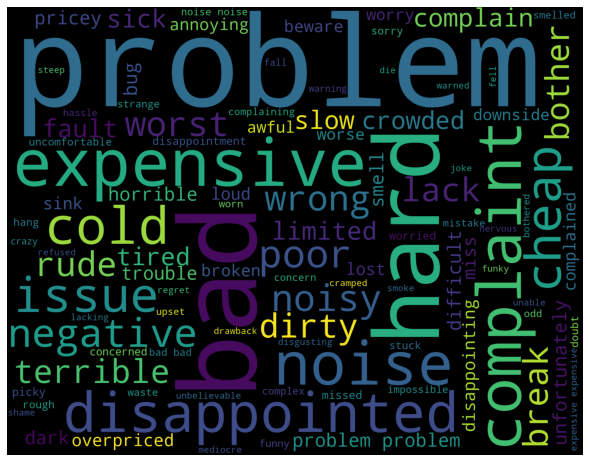

In [43]:
wordcloud_neg = WordCloud(background_color='black', width=1800, height=1400, max_words=100).generate(text_neg)
                      
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show();

# Emotion Mining

In [44]:
#Sentiment analysis
afinn = pd.read_csv('Afinn.csv', sep=',', encoding='latin-1')
afinn.shape

(2477, 2)

In [45]:
afinn.head()

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [46]:
affinity_scores = afinn.set_index('word')['value'].to_dict()

In [47]:
#Custom function :score each word in a sentence in lemmatised form, 
#but calculate the score for the whole original sentence.
import spacy
nlp = spacy.load('en_core_web_sm')
sentiment_lexicon = affinity_scores

def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score

In [52]:
pickle_out=open('calculate_sentiment.pkl','wb')
pickle.dump(calculate_sentiment,pickle_out)
pickle_out.close()

In [48]:
review['sentiment_value'] = review['Review'].apply(calculate_sentiment)

In [49]:
review['sentiment_value']

0        26
1        34
2        22
3        38
4        35
         ..
20486    12
20487    19
20488     6
20489    -8
20490    14
Name: sentiment_value, Length: 20491, dtype: int64

<AxesSubplot:xlabel='sentiment_value', ylabel='Density'>

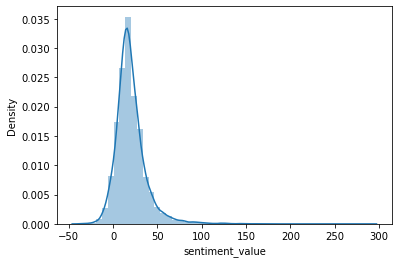

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(review['sentiment_value'])

In [51]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
review["sentiments"] = review["Review"].apply(lambda x: sid.polarity_scores(x))

review = pd.concat([review.drop(['sentiments'], axis=1), review['sentiments'].apply(pd.Series)], axis=1)

review.head()

,Review,Rating,Rating_sentiment,no_contract,content_str,no_punc,tokenized,lower,no_stopword,no_word,char_count,stp_rem_str,stemmi,lemma,cleaned,sentiment_value,neg,neu,pos,compound
0,nice hotel expensive parking got good deal sta...,4,Positive,"[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...",81,579,nice hotel expensive parking got good deal sta...,nice hotel expens park got good deal stay hote...,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,26,0.072,0.643,0.285,0.9747
1,ok nothing special charge diamond member hilto...,2,Negitive,"[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...",237,1661,ok nothing special charge diamond member hilto...,ok noth special charg diamond member hilton de...,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,34,0.110,0.701,0.189,0.9787
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral,"[nice, rooms, not, 4*, experience, hotel, mona...",nice rooms not 4* experience hotel monaco seat...,nice rooms not 4 experience hotel monaco seatt...,"[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, not, 4, experience, hotel, monac...","[nice, rooms, 4, experience, hotel, monaco, se...",211,1393,nice rooms 4 experience hotel monaco seattle g...,nice room 4 experi hotel monaco seattl good ho...,nice room 4 experience hotel monaco seattle go...,nice room experience hotel monaco seattle goo...,22,0.081,0.700,0.219,0.9889
3,"unique, great stay, wonderful time hotel monac...",5,Positive,"[unique,, great, stay,, wonderful, time, hotel...","unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...",86,582,unique great stay wonderful time hotel monaco ...,uniqu great stay wonder time hotel monaco loca...,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,38,0.060,0.555,0.385,0.9912
4,"great stay great stay, went seahawk game aweso...",5,Positive,"[great, stay, great, stay,, went, seahawk, gam...","great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...",180,1239,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,35,0.135,0.643,0.221,0.9797


In [52]:
reviews=np.array(review['cleaned'])
s=str(reviews)
token = word_tokenize(s)
print(token)

['[', "'nice", 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'review', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'nonexistent', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillow', 'soundproof', 'like', 'heard', 'music', 'room', 'night', 'morning', 'loud', 'bang', 'door', 'opening', 'closing', 'hear', 'people', 'talking', 'hallway', 'maybe', 'noisy', 'neighbor', 'aveda', 'bath', 'product', 'nice', 'goldfish', 'stay', 'nice', 'touch', 'taken', 'advantage', 'staying', 'longer', 'location', 'great', 'walking', 'distance', 'shopping', 'overall', 'nice', 'experience', 'pay', 'parking', "night'", "'ok", 'nothing', 'special', 'charge', 'diamond', 'member', 'hilton', 'decided', 'chain', 'shot', 'anniversary', 'seattle', 'start', 'booked', 'suite', 'paid', 'extra', 'website', 'description', 'suite', 'bedr

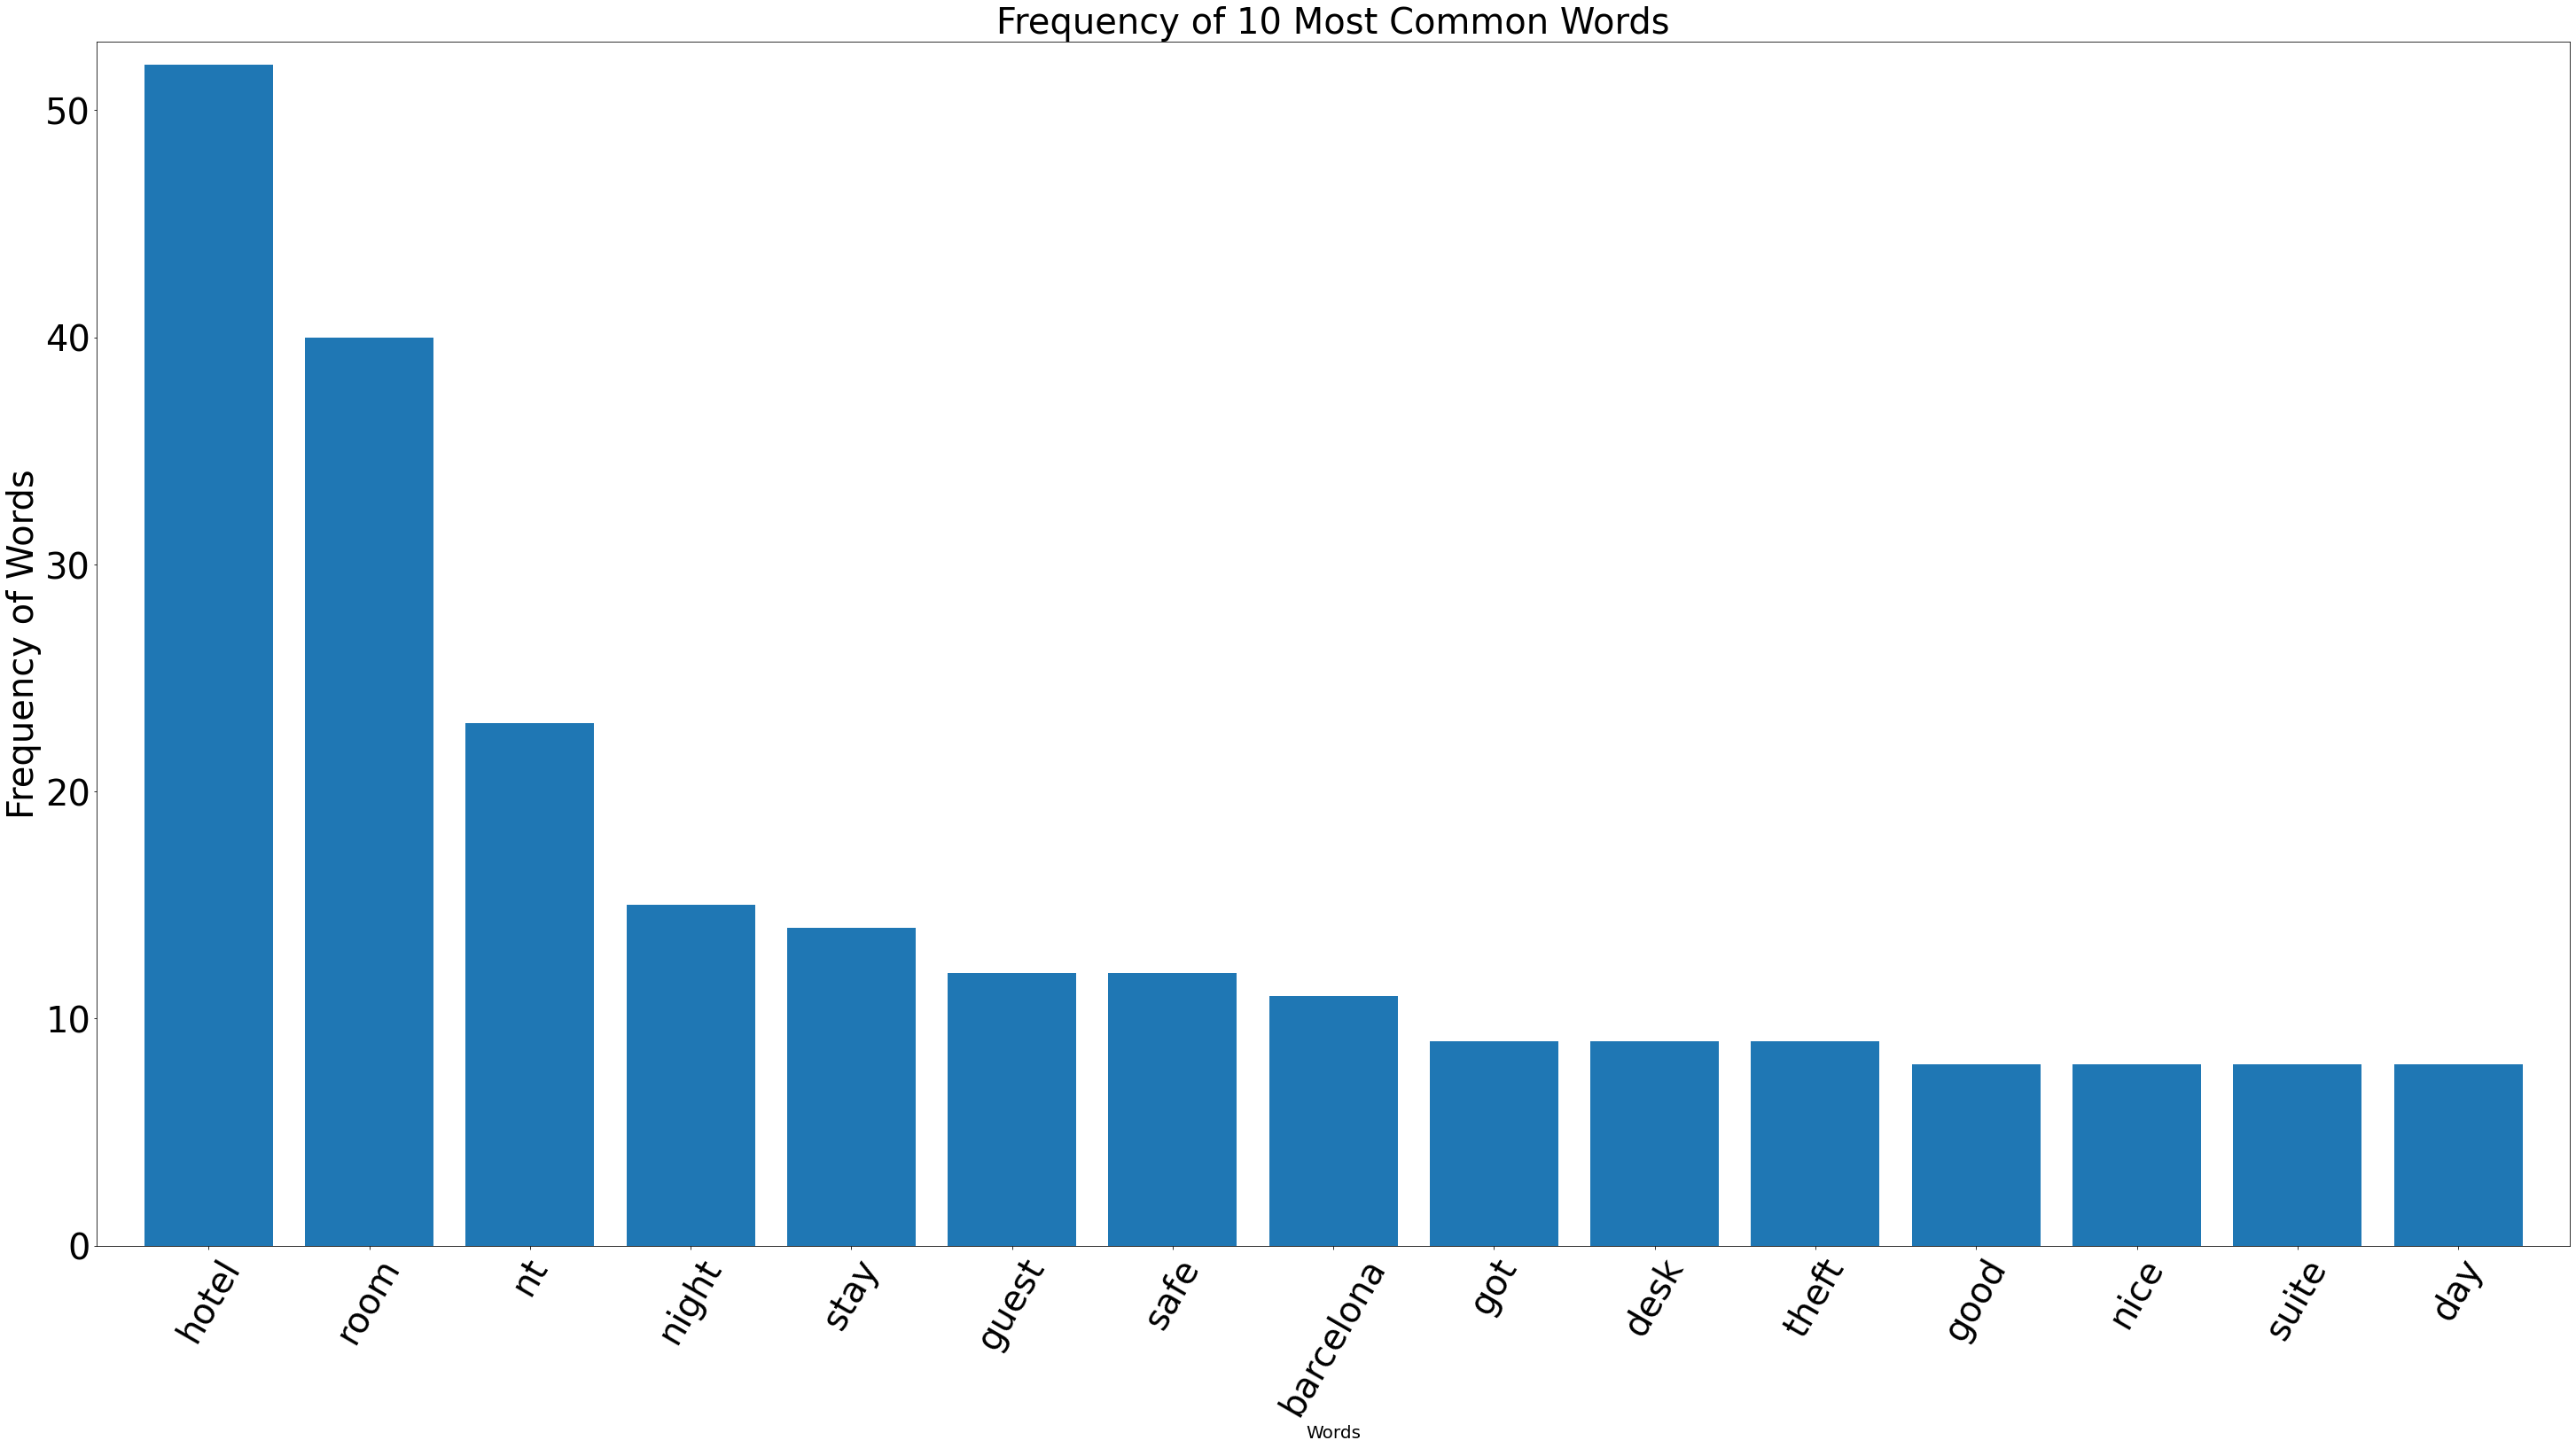

In [53]:
from nltk.probability import FreqDist
mostcommon_1 = FreqDist(token).most_common(15)
x, y = zip(*mostcommon_1)
plt.figure(figsize=(50,25))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=40)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 10 Most Common Words', fontsize=40)
plt.show()

In [67]:
final_data=review[['cleaned','Rating_sentiment']]
final_data.to_csv(r"C:\Users\Vijay Rathod\Downloads\cleaned")

In [68]:
final_data

,cleaned,Rating_sentiment
0,nice hotel expensive parking got good deal sta...,Positive
1,ok nothing special charge diamond member hilto...,Negitive
2,nice room experience hotel monaco seattle goo...,Neutral
3,unique great stay wonderful time hotel monaco ...,Positive
4,great stay great stay went seahawk game awesom...,Positive
...,...,...
20486,best kept secret time staying charm ca nt be...,Positive
20487,great location price view hotel great quick pl...,Positive
20488,ok look nice modern outside desk staff nt part...,Negitive
20489,hotel theft ruined vacation hotel opened sept ...,Negitive


In [69]:
final_data['Rating_sentiment'] = final_data['Rating_sentiment'].replace({'Negitive': -1})
final_data['Rating_sentiment'] = final_data['Rating_sentiment'].replace({'Positive': 1})
final_data['Rating_sentiment'] = final_data['Rating_sentiment'].replace({'Neutral': 0})

In [70]:
final_data

,cleaned,Rating_sentiment
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,-1
2,nice room experience hotel monaco seattle goo...,0
3,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay went seahawk game awesom...,1
...,...,...
20486,best kept secret time staying charm ca nt be...,1
20487,great location price view hotel great quick pl...,1
20488,ok look nice modern outside desk staff nt part...,-1
20489,hotel theft ruined vacation hotel opened sept ...,-1


In [72]:
y=final_data['Rating_sentiment']
y

0        1
1       -1
2        0
3        1
4        1
        ..
20486    1
20487    1
20488   -1
20489   -1
20490   -1
Name: Rating_sentiment, Length: 20491, dtype: int64

In [74]:
corpus = final_data['cleaned'].tolist()

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
df_tf_idf= vectorizer.fit_transform(corpus).toarray()

In [90]:
x_tfidf = pd.DataFrame(df_tf_idf)
x_tfidf

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.142999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041057,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
ydf=pd.DataFrame(y)
posi,neg,neu=ydf.value_counts()
posi

15093

In [151]:
import pickle
pickle_out=open('vectorizer.pkl','wb')
pickle.dump(vectorizer,pickle_out)
pickle_out.close()

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [95]:
x_traintfidf, x_testtfidf,y_traintfidf,y_testtfidf = train_test_split(x_tfidf,ydf, test_size=0.35,random_state=0)
x_traintfidf.shape,y_traintfidf.shape, x_testtfidf.shape,y_testtfidf.shape

((13319, 5000), (13319, 1), (7172, 5000), (7172, 1))

# Balancing the splited data using SMOTE method

In [96]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_traintfidf1, y_traintfidf1 = oversample.fit_resample(x_traintfidf, y_traintfidf)

In [100]:
classifier2 = LogisticRegression(solver='lbfgs', max_iter=500, multi_class='multinomial')
classifier2.fit(x_traintfidf, y_traintfidf)
log_pred_test = classifier2.predict(x_testtfidf)
log_pred_train=classifier2.predict(x_traintfidf)
acc_log_train2=accuracy_score(y_traintfidf,log_pred_train)*100
acc_log_test2 = accuracy_score(y_testtfidf, log_pred_test) * 100
print('Accuracy of Training data =',acc_log_train2)
print("Accuracy of Test data =", acc_log_test2)

Accuracy of Training data = 90.44973346347324
Accuracy of Test data = 85.13664249860568


In [104]:
classifier4 = RandomForestClassifier(n_estimators=400)
classifier4.fit(x_traintfidf, y_traintfidf)
pred_test = classifier4.predict(x_testtfidf)
pred_train=classifier4.predict(x_traintfidf)
acc_train4=accuracy_score(y_traintfidf,pred_train)*100
acc_test4 = accuracy_score(y_testtfidf, pred_test) * 100
print('Accuracy of Training data =',acc_train4)
print("Accuracy of Test data =", acc_test4)

Accuracy of Training data = 100.0
Accuracy of Test data = 80.47964305633018


In [102]:
model = LinearSVC()
model.fit(x_traintfidf, y_traintfidf)
pred_test = model.predict(x_testtfidf)
pred_train=model.predict(x_traintfidf)
acc_train6=accuracy_score(y_traintfidf,pred_train)*100
acc_test6 = accuracy_score(y_testtfidf, pred_test) * 100
print('Accuracy of Training data =',acc_train6)
print("Accuracy of Test data =", acc_test6)

Accuracy of Training data = 96.1258352729184
Accuracy of Test data = 84.21639709983269


In [144]:
model12 = MultinomialNB()
model12.fit(x_traintfidf, y_traintfidf)
pred_test = model12.predict(x_testtfidf)
pred_train=model12.predict(x_traintfidf)
acc_train10=accuracy_score(y_traintfidf,pred_train)*100
acc_test10 = accuracy_score(y_testtfidf, pred_test) * 100
print('Accuracy of Training data =',acc_train10)
print("Accuracy of Test data =", acc_test10)

Accuracy of Training data = 83.18942863578347
Accuracy of Test data = 81.20468488566648


In [115]:
Ada_model=AdaBoostClassifier()
Ada_model.fit(x_traintfidf, y_traintfidf)
pred_test = Ada_model.predict(x_testtfidf)
pred_train=Ada_model.predict(x_traintfidf)
add_train=accuracy_score(y_traintfidf,pred_train)*100
add_test= accuracy_score(y_testtfidf, pred_test) * 100
print('Accuracy of Training data =',add_train)
print("Accuracy of Test data =", add_test)

Accuracy of Training data = 83.33208198813725
Accuracy of Test data = 81.19074177356386


In [116]:
AS={'Models':['Logistic Regression (TFIDF)', 'Random Forest(TFIDF)', 'LinearSVC(TFIDF)', 'Multinomial Naive Bayes(TFIDF)','Add Boost(TFIDF)'],
    'Train Accuracy':[acc_log_train2,acc_train4,acc_train6,acc_train10,add_train]
    ,'Test Accuracy':[acc_log_test2,acc_test4,acc_test6,acc_test10,add_test]}

In [117]:
Model=pd.DataFrame(AS)
Model

,Models,Train Accuracy,Test Accuracy
0,Logistic Regression (TFIDF),90.449733,85.136642
1,Random Forest(TFIDF),100.000000,80.479643
2,LinearSVC(TFIDF),96.125835,84.216397
3,Multinomial Naive Bayes(TFIDF),83.189429,81.204685
4,Add Boost(TFIDF),83.332082,81.190742


In [118]:
def clean_text(a):
    print("Number of words in Review:", len(a.split()))
    text=re.sub('[^A-za-z0-9]',' ',a)
    text=text.lower()
    text=text.split(' ')
    text = ' '.join(text)
    top2_words = get_top_n2_words([text],n=5) 
    df = pd.DataFrame(top2_words)
    df.columns=["Bi-gram", "Freq"]
    print(df)
   
    return text

In [119]:
def expression_check(prediction_input):
    if prediction_input == -1:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print(" Input statement has Neutral Sentiment.")


In [145]:
# function to take the input statement and perform the same transformations we did earlier
def sentiment_predictor(input):
    input = clean_text(input)
    transformed_input = vectorizer.transform([input])
    prediction = model12.predict(transformed_input)
    expression_check(prediction)

In [146]:
a=('it was amazing')

In [147]:
sentiment_predictor(a)

Number of words in Review: 3
       Bi-gram  Freq
0       it was     1
1  was amazing     1
Input statement has Positive Sentiment.


In [148]:
b=('the worst hotel')

In [149]:
sentiment_predictor(b)

Number of words in Review: 3
       Bi-gram  Freq
0    the worst     1
1  worst hotel     1
Input statement has Negative Sentiment.


In [150]:
pickle_out=open('model12.pkl','wb')
pickle.dump(model12,pickle_out)
pickle_out.close()